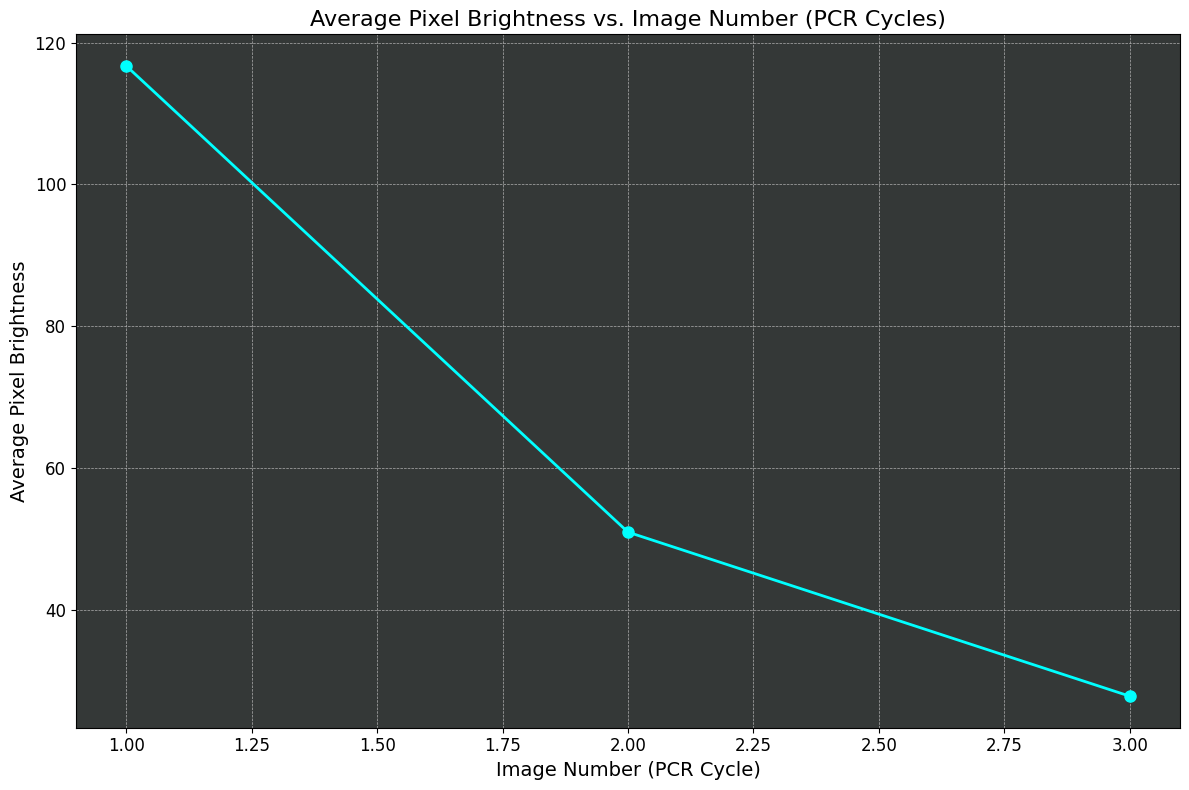

In [2]:
import os
import re
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Folder containing data
image_folder = "raw_images"

# Function to extract the numerical part of the filename
def extract_number(filename):
    return int(re.search(r'\d+', filename).group())

# Lists to store average brightness and image numbers
average_brightness = []
image_numbers = []

# Process each image in the folder
for idx, image_file in enumerate(sorted(os.listdir(image_folder), key=extract_number)):
    if image_file.endswith(".png"):  # Only process .png files
        # Load the image
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert("L")  # Convert to grayscale

        # Calculate the average pixel brightness
        image_array = np.array(image)
        avg_brightness = np.mean(image_array)

        # Store the results
        average_brightness.append(avg_brightness)
        image_numbers.append(idx + 1)  # Store the image number (PCR cycle step)

# Create a Matplotlib figure
plt.figure(figsize=(12, 8))

# Plot average brightness vs image number
plt.plot(image_numbers, average_brightness, marker='o', color='cyan', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.title('Average Pixel Brightness vs. Image Number (PCR Cycles)', fontsize=16)
plt.xlabel('Image Number (PCR Cycle)', fontsize=14)
plt.ylabel('Average Pixel Brightness', fontsize=14)

# Customize the grid and background
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('xkcd:charcoal')

# Customize the axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
